In [5]:
print("Hello World")

Hello World


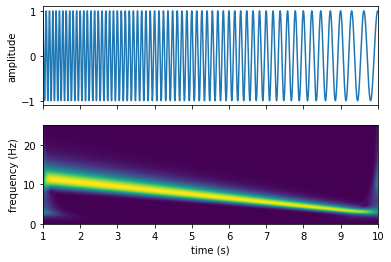

In [68]:
import numpy as np
import stockwell
from scipy.signal import chirp
import matplotlib.pyplot as plt
import st

t = np.linspace(1, 10, 5001)
w = chirp(t, f0=12.5, f1=2.5, t1=10, method='linear')

fmin = 0  # Hz
fmax = 25  # Hz
df = 1./(t[-1]-t[0])  # sampling step in frequency domain (Hz)
fmin_samples = int(fmin/df)
fmax_samples = int(fmax/df)
stock = st.st(w, fmin_samples, fmax_samples)
extent = (t[0], t[-1], fmin, fmax)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, w)
ax[0].set(ylabel='amplitude')
ax[1].imshow(np.abs(stock), origin='lower', extent=extent)
ax[1].axis('tight')
ax[1].set(xlabel='time (s)', ylabel='frequency (Hz)')
plt.show()

/Users/admin/Desktop/anaconda3/envs/synthetic_audio/lib/python3.7/site-packages/ipykernel_launcher.py:66: WavFileWarning: Reached EOF prematurely; finished at 2947180 bytes, expected 2947188 bytes from header.
/Users/admin/Desktop/anaconda3/envs/synthetic_audio/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10


frameSize: 1024


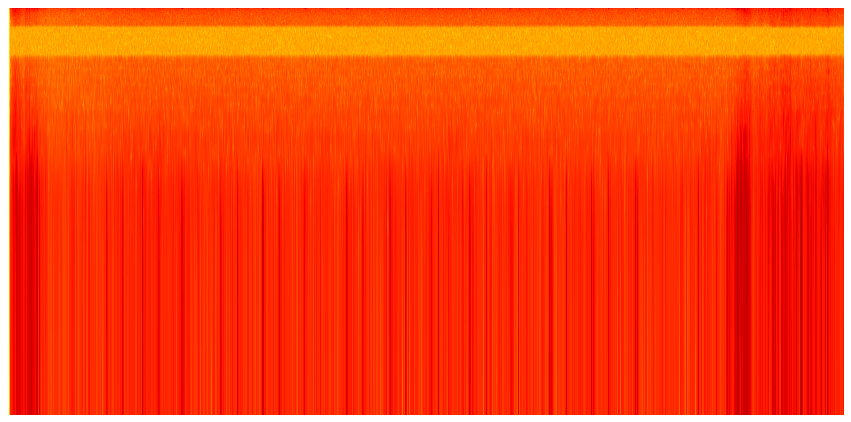

<Figure size 432x288 with 0 Axes>

In [84]:
#use this for audio that people send me, single use

import os
import wave
import pylab
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal.windows as wind
from numpy.lib import stride_tricks

binsize=2**10
plotpath='things'
colormap="jet"

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=wind.gaussian):
    win = window(frameSize,20,40)

    print("frameSize: " + str(frameSize))
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs



file_name = '/Users/admin/desktop/ML-heart-beat/heartbeat-sounds/stuff/nicoheartbeat.wav'

samplerate, samples = wav.read(file_name)

file_name = file_name[:-4]


s = stft(samples, binsize)

sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

timebins, freqbins = np.shape(ims)


plt.figure(figsize=(15, 7.5))
plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="bicubic")

plt.axis('off')
plt.yscale('symlog')


#plt.savefig('nicoHeartBeatGraph', bbox_inches="tight")

#clears the entire current figure with all its axes,
#but leaves the window opened, such that it may be reused for other plots.
plt.show()
plt.clf()